In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
from torch import nn
import matplotlib.pyplot as plt

## Extraccion de caracteristicas

In [3]:
from concurrent.futures import ThreadPoolExecutor

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=2000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

def process_row(row, data_dir):
    file_name = f"train/train/{row['idx']}.wav"
    file_path = os.path.join(data_dir, file_name)
    if os.path.exists(file_path):
        features = extract_features(file_path)
        label = 1 if row['class'] == 'RightWhale' else 0
        return features, label
    return None

def encode(data_dir, csv_file, max_workers=4):
    df = pd.read_csv(os.path.join(data_dir, csv_file))
    data = []
    labels = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_row, row, data_dir) for _, row in df.iterrows()]
        for future in futures:
            result = future.result()
            if result:
                features, label = result
                data.append(features)
                labels.append(label)

    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [4]:
data_dir = './data/'
train_csv = 'train.csv'



x_path = './data/encoded_x.csv'
y_path = './data/encoded_y.csv'

if os.path.exists(x_path) and os.path.exists(y_path):
  x = np.loadtxt(x_path, delimiter=',')
  y = np.loadtxt(y_path, delimiter=',')
else:
  x, y = encode(data_dir, train_csv, max_workers=4)
  np.savetxt(x_path, x, delimiter=',')
  np.savetxt(y_path, y, delimiter=',')



## Aplicamos normalizacion

In [5]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

## Aplicamos PCA como reduccion de dimensioalidad

In [6]:
pca = PCA()
pca.fit(x_scaled)

PCA()

Número óptimo de componentes principales: 11


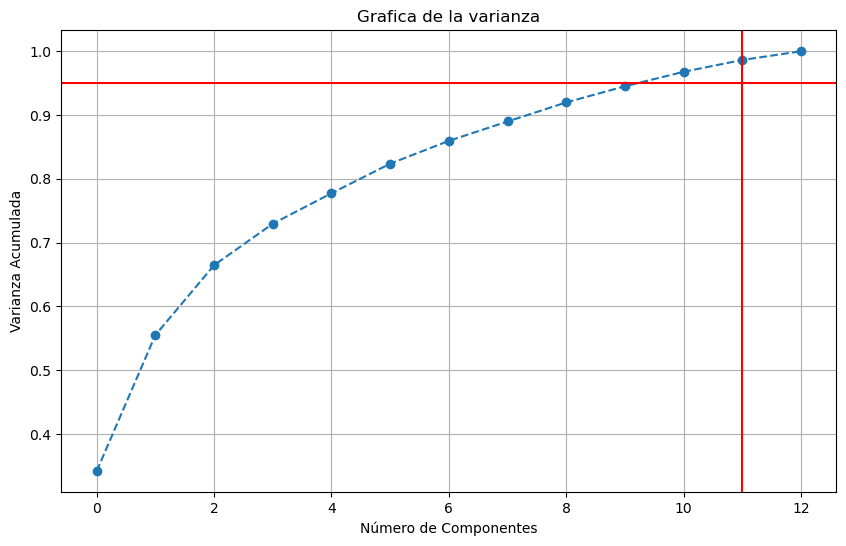

In [7]:

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


n_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f'Número óptimo de componentes principales: {n_components}')

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=n_components, color='r', linestyle='-')
plt.title('Grafica de la varianza')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.show()

In [8]:
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(x_scaled)

## Realizamos split para tener train y test

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)


## Clustering

In [11]:
import seaborn as sns

def matriz_confusion(y_test, y_pred, Tipo):
  matrix = confusion_matrix(y_test, y_pred)
  f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index=["NoWhale", "RightWhale"], columns=["NoWhale", "RightWhale"])

  sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
  plt.title("Confusion Matrix " + Tipo), plt.tight_layout()
  plt.xlabel("Predicted")
  plt.ylabel("Real")
  plt.show()

def test_clustering(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)

  print(f'Accuracy: {accuracy}')
  print(f'F1 Score: {f1}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  matriz_confusion(y_test, y_pred, "Test")

### K-Means++

In [13]:
def distance(v1, v2, ax=None):
  return np.linalg.norm(v1-v2, axis=ax)


def get_init_centroids(data, k):
  n, m = data.shape
  centroids = np.empty((k, m))
  centroids[0] = data[np.random.choice(n)]
  for i in range(1, k):
    dists = np.min([distance(data, centroids[j], 1)**2 for j in range(i)], axis=0)
    probs = dists/dists.sum()
    cum_probs = np.cumsum(probs)
    r = np.random.rand()
    for j, p in enumerate(cum_probs):
      if r < p:
        centroids[i] = data[j]
        break
  return centroids


def get_new_centroids(clusters, data, k):
  new_centroids = np.array([
      np.mean(data[clusters == i], axis=0) if np.any(clusters == i) else data[np.random.choice(data.shape[0])]
      for i in range(k)
  ])
  return new_centroids


def get_cluster(data, centroids):
  dists = distance(data[:, np.newaxis], centroids, 2)
  clusters = np.argmin(dists, axis=1)
  return clusters


def avg_centroids_dist(old_centroids, new_centroids):
  avg = []
  for i in range(old_centroids.shape[0]):
      dist = distance(old_centroids[i], new_centroids[i])
      avg.append(dist)
  return np.mean(avg)


def kmeans(data, k, threshold):
  centroids = get_init_centroids(data, k)
  clusters = get_cluster(data, centroids)
  new_centroids = get_new_centroids(clusters, data, k)

  while avg_centroids_dist(centroids, new_centroids) > threshold:
     centroids = new_centroids
     clusters = get_cluster(data, centroids)
     new_centroids = get_new_centroids(clusters, data,k)

  return clusters

Accuracy: 0.7361682670324645
F1 Score: 0.7600831600831601
Precision: 0.7157400156617071
Recall: 0.8102836879432624


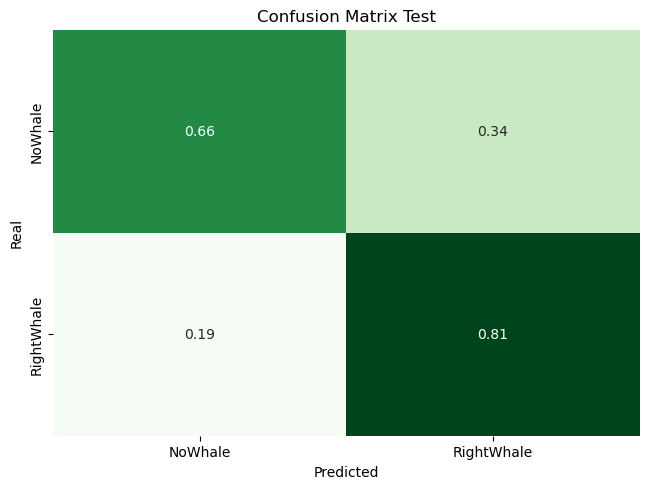

In [14]:
y_pred_kmeans = kmeans(x_test, 2, 0.01)
test_clustering(y_test, y_pred_kmeans)

In [17]:
def get_final_centroids(data, clusters, k):
    centroids = np.array([
        np.mean(data[clusters == i], axis=0) if np.any(clusters == i) else data[np.random.choice(data.shape[0])]
        for i in range(k)
    ])
    return centroids

In [18]:
centroids = get_final_centroids(x_test, y_pred_kmeans, 2)

In [21]:

def plot_clusters(data, clusters, centroids):
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
    plt.title('Clusters and Centroids')
    
    plt.show()

def plot_centroids(data, clusters, centroids):
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
    plt.title('Clusters and Centroids')
   
    plt.legend()
    plt.show()

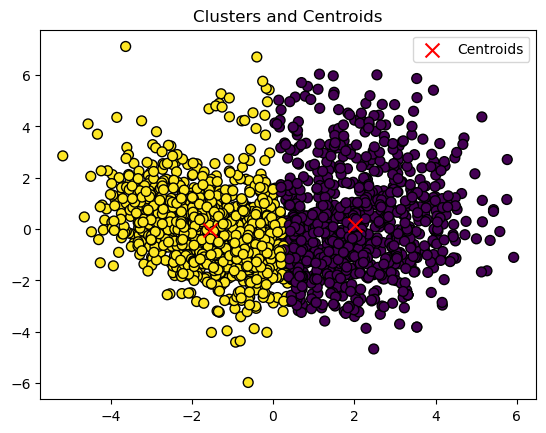

In [22]:
plot_centroids(x_test, y_pred_kmeans, centroids)
